In [6]:
import pywt

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import mne
import pywt
import pyedflib
import pylab
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
from scipy import signal
from scipy.fft import fft, fftfreq

In [9]:
import pyedflib
import numpy as np

def read_edf(file_path):
    with pyedflib.EdfReader(file_path) as f:
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        signals = np.zeros((n, f.getNSamples()[0]))
        for i in range(n):
            signals[i, :] = f.readSignal(i)
    return signals, signal_labels

# Пример вызова функции
file_path = "/home/omar/Рабочий стол/analytics/physionet.org/files/chbmit/1.0.0/chb08/chb08_02.edf"  # Укажите правильный путь
signals, labels = read_edf(file_path)
print("Метки сигналов:", labels)
print("Данные сигналов:", signals.shape)

Метки сигналов: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
Данные сигналов: (23, 921600)


In [41]:
def save_wavelet_transform(signal, file_name, output_dir, start_time, end_time, sampling_rate, time_label):

    #scales = np.logspace(np.log10(scale_min), np.log10(scale_max), num = 25, endpoint=True, base=10.0)
    scale_max = [200, 50, 26, 14, 6]
    scale_min = [50, 26, 14, 6, 3.5]
    wavelet_core = 'morl'
    dt = 1 / sampling_rate
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    #plt.figure(figsize = (10, 10))
    #plt.title(f'Wavelet Transform of {file_name}')
    #plt.axis('off')
    v_max = [240, 120, 40, 30, 20]
    # ax.set_title(f'Wavelet Transform of {file_name}')
    for k in range(len(signal)):
            scales = np.linspace(scale_min[k], scale_max[k], num=25, endpoint=True)
            coef, freqs = pywt.cwt(signal[k], scales, wavelet_core, sampling_period=dt)
            frequencies = pywt.scale2frequency(wavelet_core, scales) / dt
            # изобразим график зависимости частоты и масштаба
            # plt.figure(figsize=(7, 7))
            # plt.grid()
            # plt.yticks(np.arange(min(freqs), max(freqs), (max(freqs) - min(freqs))/10))
            # plt.xticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/10))
            # plt.ylabel('Частота[Герц]', fontsize=12)
            # plt.xlabel('масштаб в вейвлет преобразовании', fontsize=12)
            # plt.plot(scales, freqs,'.-')

            # Создаем кастомную цветовую карту от синего до красного с пределами мощности от 0 до 20
            colors = [(0, 'blue'), (0.5, 'cyan'), (0.9, 'yellow'), (1, 'darkred')]
            custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
            ax = plt.subplot(5, 1, k + 1)

            extent = [start_time, end_time, frequencies[-1], frequencies[0]]  # Устанавливаем частоту на вертикальной оси
            # Используем фиксированные пределы vmin=0 и vmax=20
            img = ax.imshow(np.abs(coef), extent=extent, cmap=custom_cmap, aspect='auto', vmin=0, vmax=v_max[k])
            # plt.colorbar(label='Magnitude')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_xlabel('Time (seconds)')
            # plt.axis('off')
            ax.set_ylim(frequencies[-1], frequencies[0])

            # Сохранение изображения
    output_path = os.path.join(output_dir, f'{file_name}_{time_label}_wavelet.png')
    plt.savefig(output_path)
    plt.show()
    plt.close()
    return output_path
     

In [10]:
def parse_summary_file(summary_file_path):
    edf_files = []
    with open(summary_file_path, 'r') as file:
        content = file.read()
        files = re.split(r'File Name: ', content)[1:]  # Разделение по файлам
        for file_info in files:
            lines = file_info.split('\n')
            file_name = lines[0].strip()
            seizure_start = []
            seizure_end = []
            num_seizures = 0
            k=0
            for line in lines[1:]:
                if 'Number of Seizures in File' in line:
                    num_seizures = int(line.split(':')[-1].strip())
                    k=num_seizures
                    continue

                if k > 0:
                    if ('Seizure' in line)and('Start Time' in line):
                        seizure_start_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_start.append(seizure_start_i)
                        continue

                    if ('Seizure' in line)and('End Time' in line):
                        seizure_end_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_end.append(seizure_end_i)
                        k-=1
                        continue

            edf_files.append({
                'file_name': file_name,
                'seizure_start': seizure_start,
                'seizure_end': seizure_end,
                'num_seizures': num_seizures
            })
    return edf_files

In [11]:
#процедура для фильтрации (выделению) из всего сигнала диапазонов частот
def butter_bandpass_filter(data, fs, plot_signal=False, order=5):
    # Определение диапазонов фильтрации
    lowcut = [1, 4, 8, 14, 30]
    highcut = [4, 8, 14, 20, 50]
    nyquist = 0.5 * fs
    # Список для хранения отфильтрованных сигналов
    filtered_signals = []
    # Фильтрация для каждого диапазона частот
    for i in range(len(lowcut)):
        low = lowcut[i] / nyquist
        high = highcut[i] / nyquist
        b, a = signal.butter(order, [low, high], btype='band')
        filtered_data = signal.lfilter(b, a, data)
        filtered_signals.append(filtered_data)
    # Построение спектров
    #plt.figure(figsize=(7, 5))
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    for i, filtered_data in enumerate(filtered_signals):
        # Преобразование Фурье
        signal_fft = fft(filtered_data)
        # Амплитуды и частоты
        amplitudes = np.abs(signal_fft) / len(filtered_data)
        frequencies = fftfreq(len(filtered_data), 1 / fs)

        # Отбираем только положительные частоты
        positive_freqs = frequencies > 0
        frequencies = frequencies[positive_freqs]
        amplitudes = amplitudes[positive_freqs]

        # Построение графика спектра
        # Построение спектра
        #if plot_signal:
        #        plt.plot(frequencies, amplitudes, label = leg[i])
        #        plt.xlim([0, 60])
        #        plt.title("Спектр сигнала")
        #        plt.xlabel("Частота (Гц)")
        #        plt.ylabel("Амплитуда")
    #if plot_signal:
    #  plt.legend(loc='best')
    #  plt.tight_layout()
    #  plt.grid(which='minor')
    #  plt.show()

    return filtered_signals

In [12]:
# процедура выделения из всего сигнала окна для выгрузки части сионала
def measured(signal,window_size,sampling_time):
    window_size = int(window_size * sampling_time)
    a = 0
    b = window_size
    n = signal.size/window_size
    f_signal = np.copy(signal)
    for i in range(int(n)):
        a = i*window_size
        b = (i+1)*window_size
        f_signal[a:b] = signal[a:b] - np.mean(signal[a:b])
    return f_signal

# процедура осреднения сигнала - убираем постоянную составляющую
def mean_delete(filtered_alpha,window_count,sampling_rate,time,plot_signal=False):
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    leg2 = ["Delta_m", "Theta_m","Alpha_m", "Beta_m","Gamma_m"]
    processed_signals = []
    plt.figure(figsize =(15,7))
    fig, axes = plt.subplots(5, 1, figsize=(12, 12))
    for i in range(5):
        filtered_1 = filtered_alpha[i]
        filtered_2 = measured(filtered_1,window_count,sampling_rate)
        processed_signals.append(filtered_2)
        if plot_signal:
          pylab.subplot (5, 1, i+1)
          plt.plot(time, filtered_1, label = leg[i])
          plt.plot(time, filtered_2, label = leg2[i])
          plt.legend(loc = "best")
          plt.xlim([2310, 2311])

    return processed_signals

## Make Dataset from EDF file

In [16]:
import os
# Директория для сохранения изображений на Google Диске
output_dir = os.path.join(os.getcwd(), 'wavelet_img')
os.makedirs(output_dir, exist_ok=True)

In [20]:

# количество записей EDF
amount_of_rawedf = 24
os.chdir('content')
!ls

<Figure size 1080x504 with 0 Axes>

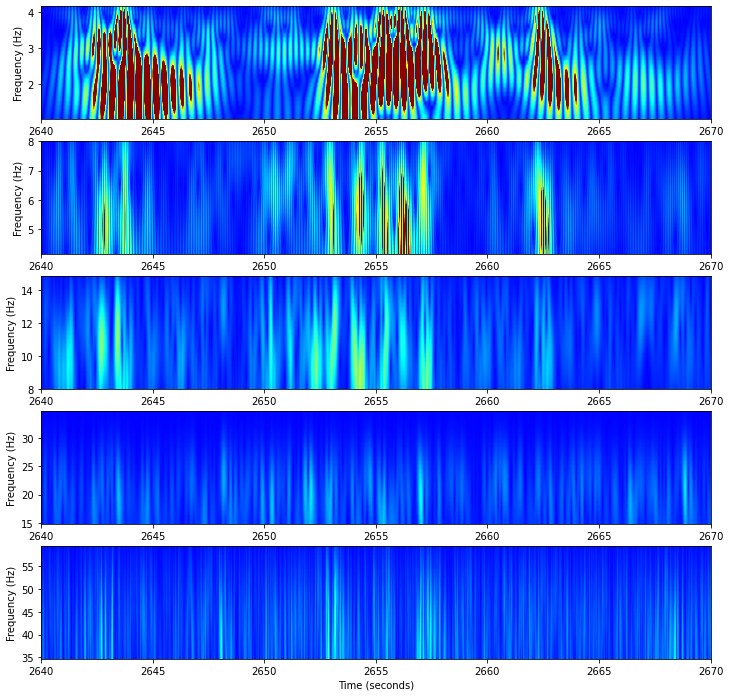

<Figure size 1080x504 with 0 Axes>

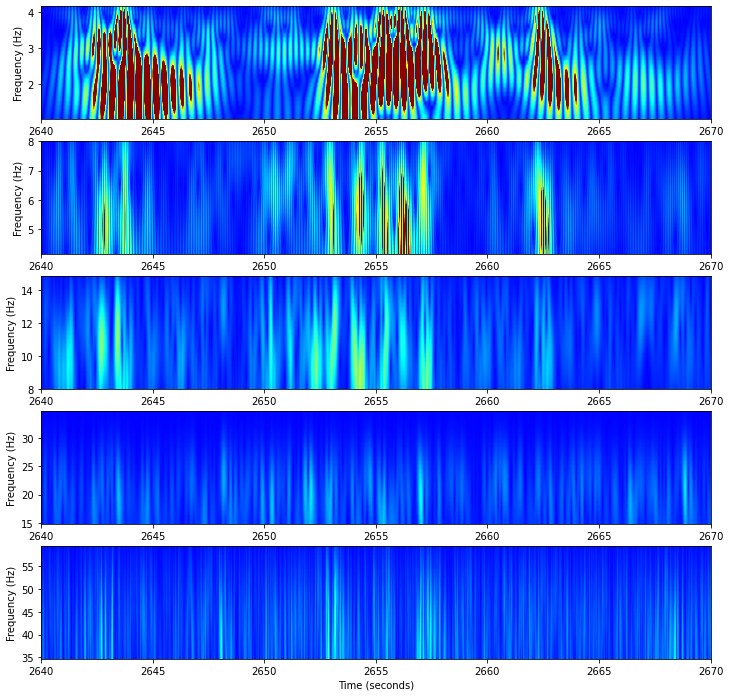

<Figure size 1080x504 with 0 Axes>

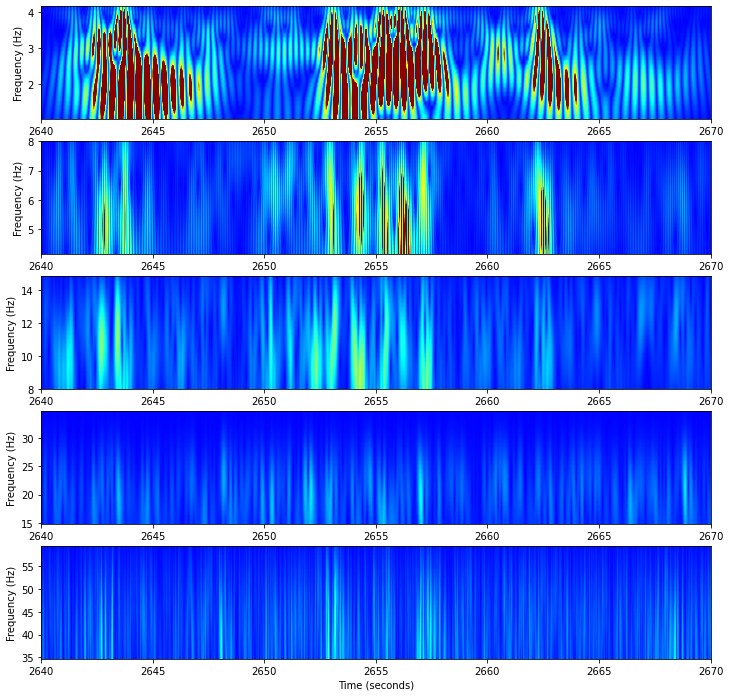

<Figure size 1080x504 with 0 Axes>

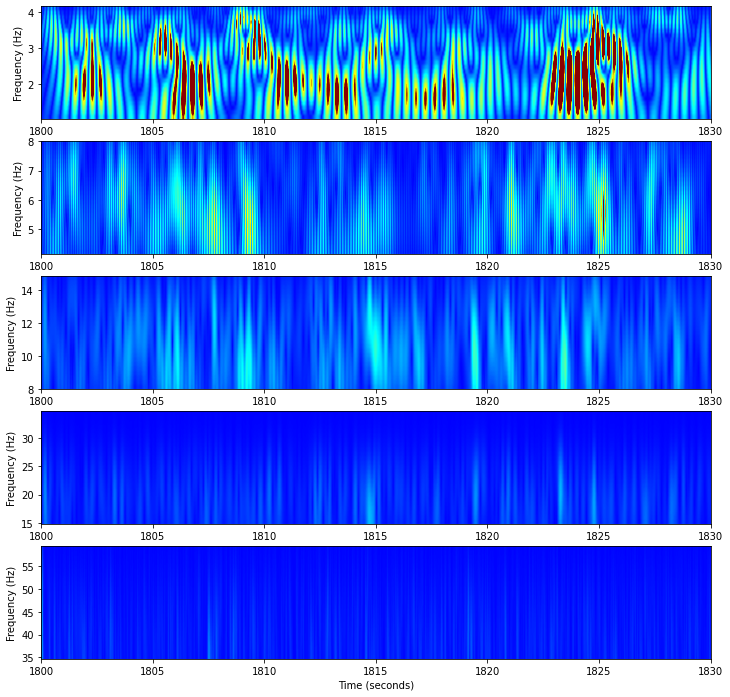

<Figure size 1080x504 with 0 Axes>

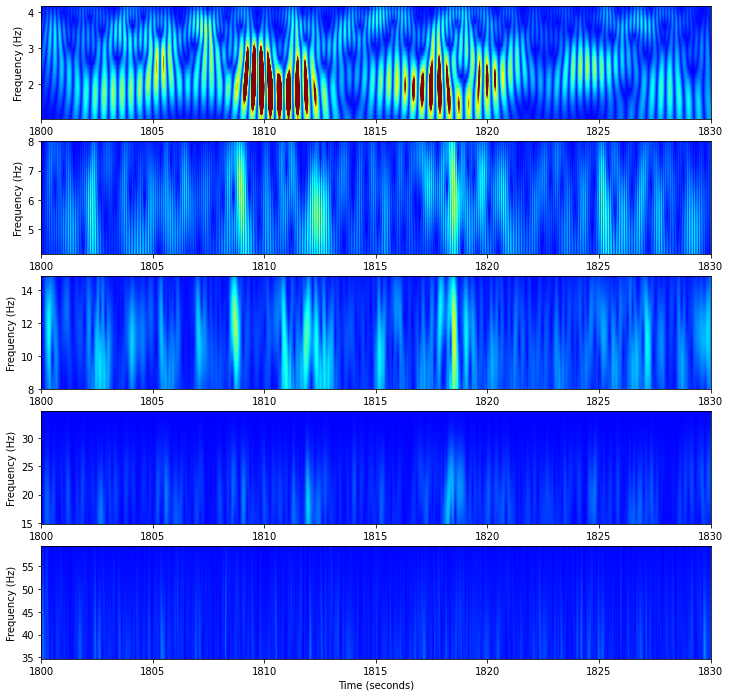

<Figure size 1080x504 with 0 Axes>

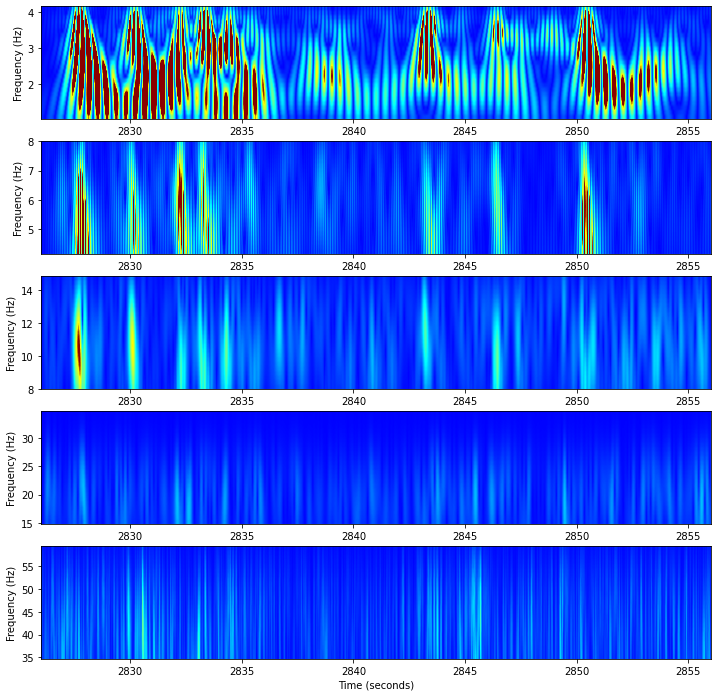

<Figure size 1080x504 with 0 Axes>

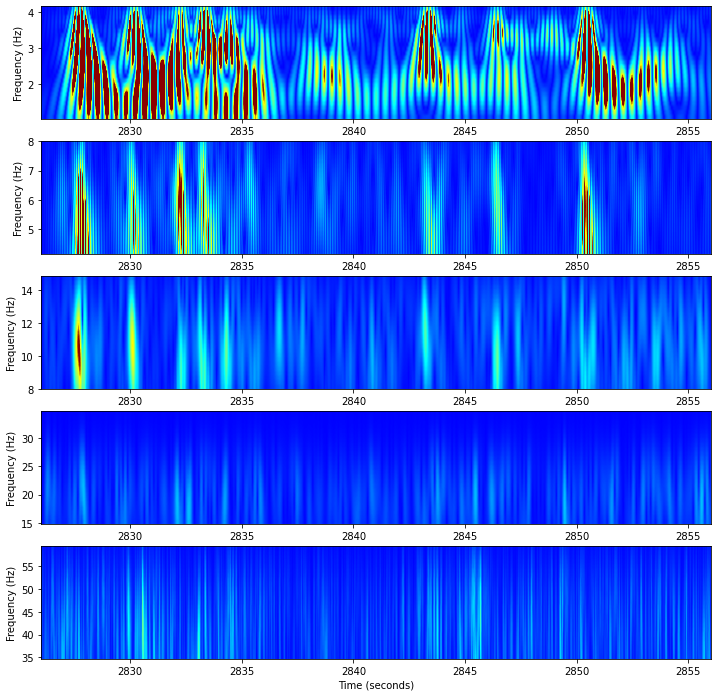

<Figure size 1080x504 with 0 Axes>

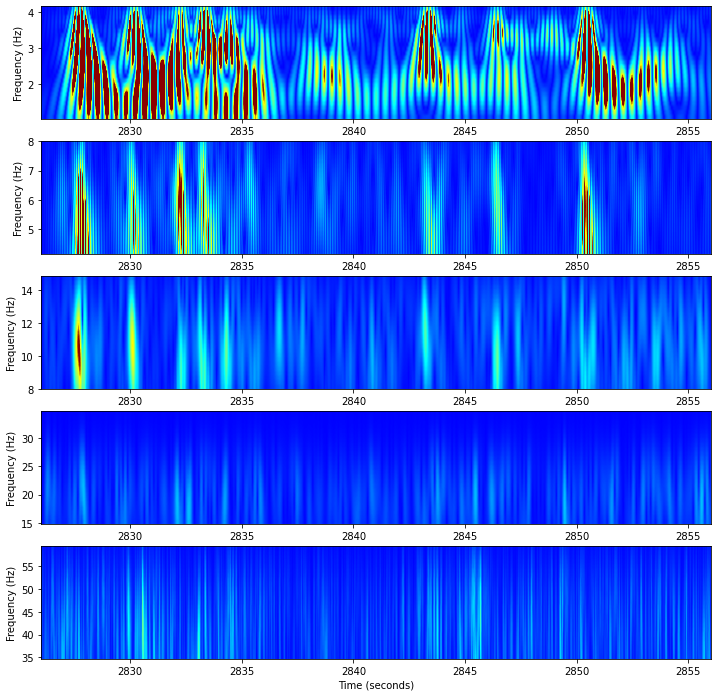

<Figure size 1080x504 with 0 Axes>

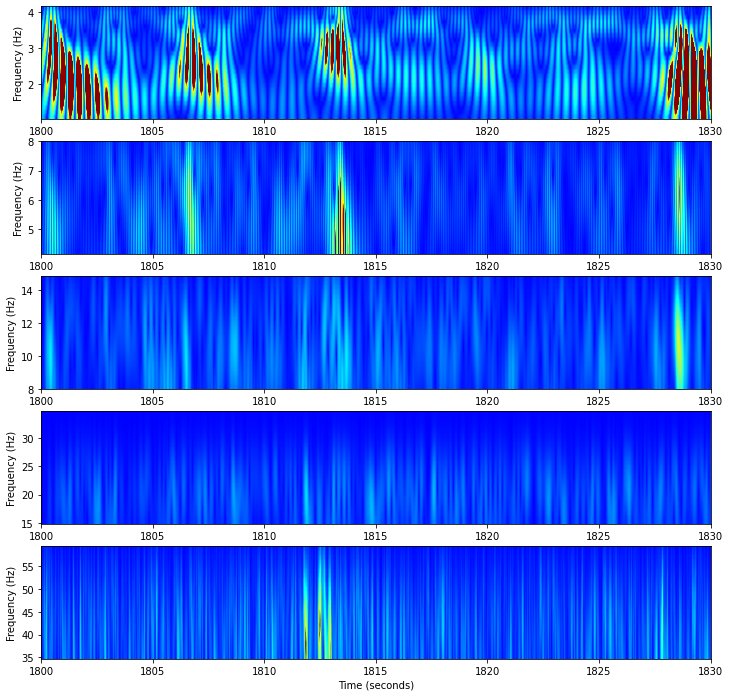

<Figure size 1080x504 with 0 Axes>

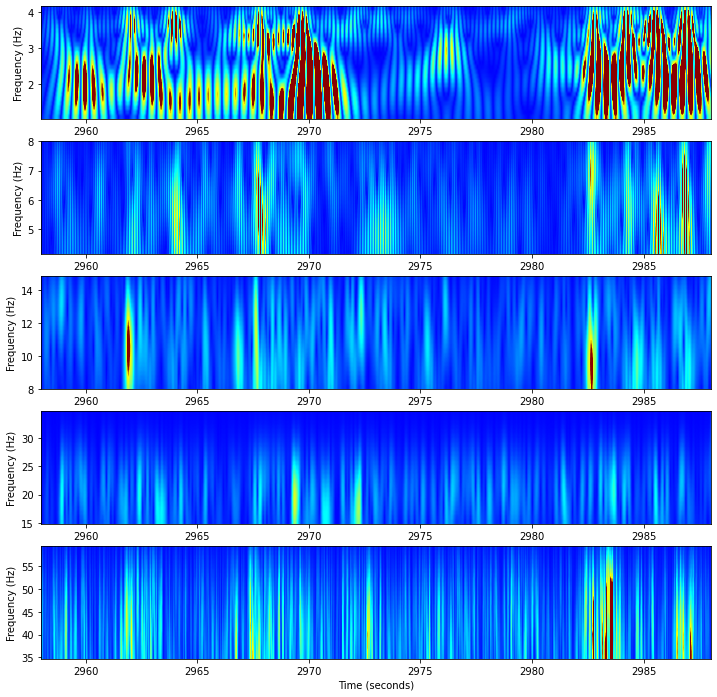

<Figure size 1080x504 with 0 Axes>

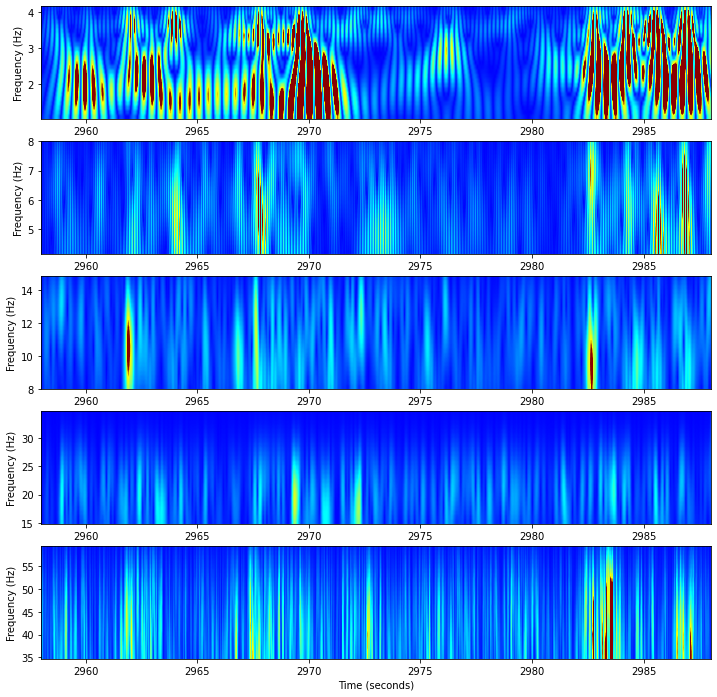

<Figure size 1080x504 with 0 Axes>

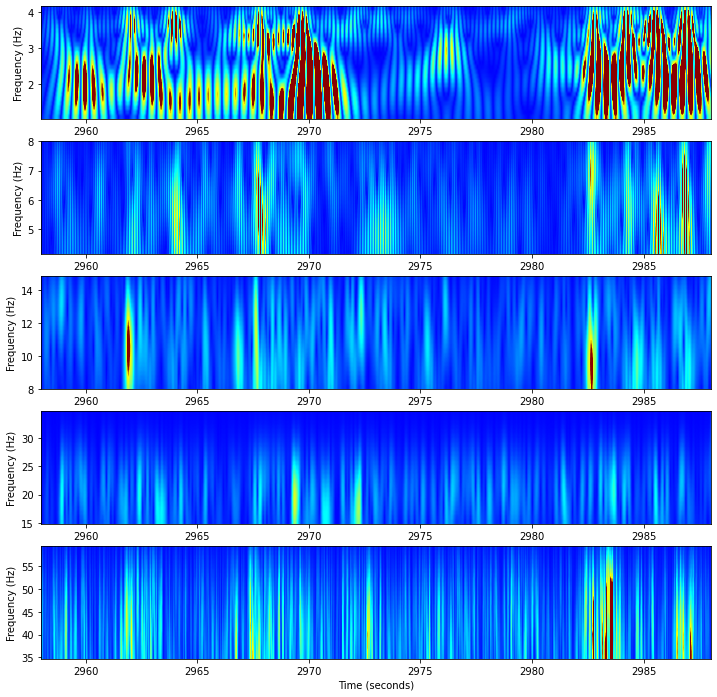

<Figure size 1080x504 with 0 Axes>

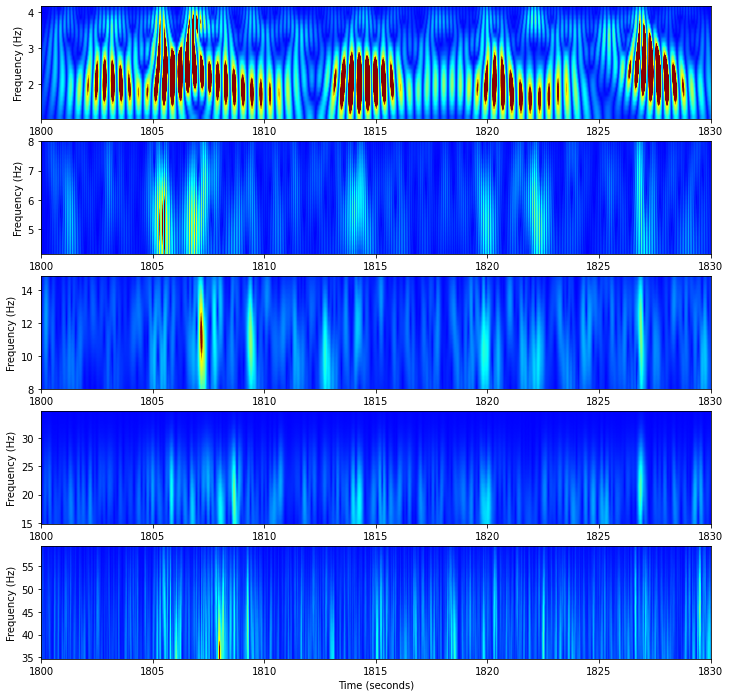

<Figure size 1080x504 with 0 Axes>

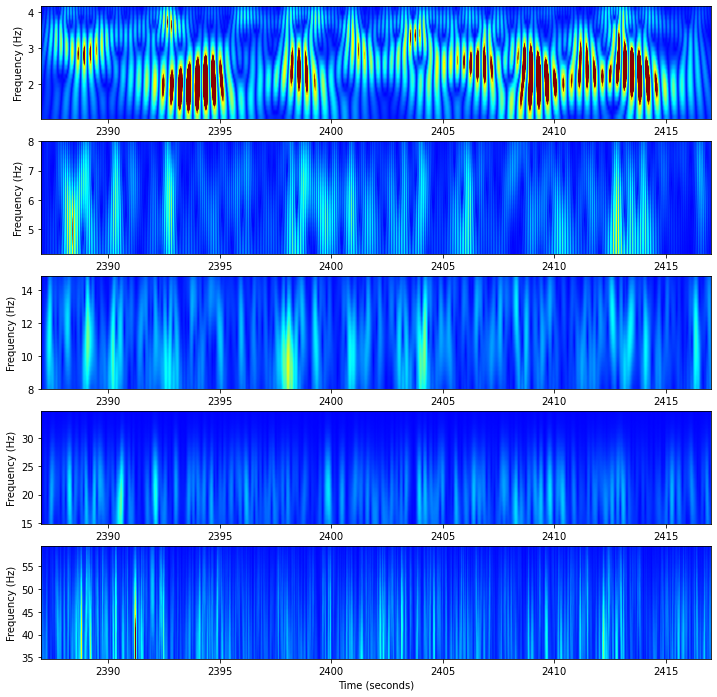

<Figure size 1080x504 with 0 Axes>

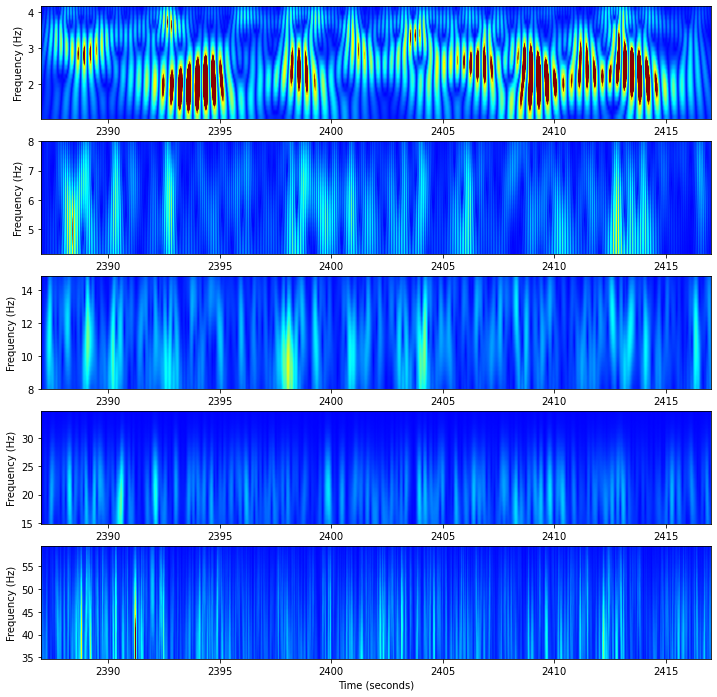

<Figure size 1080x504 with 0 Axes>

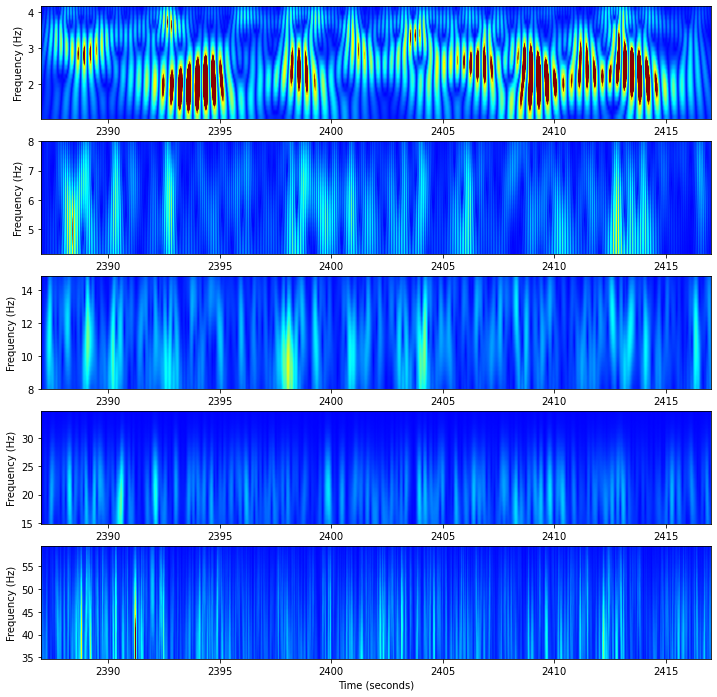

<Figure size 1080x504 with 0 Axes>

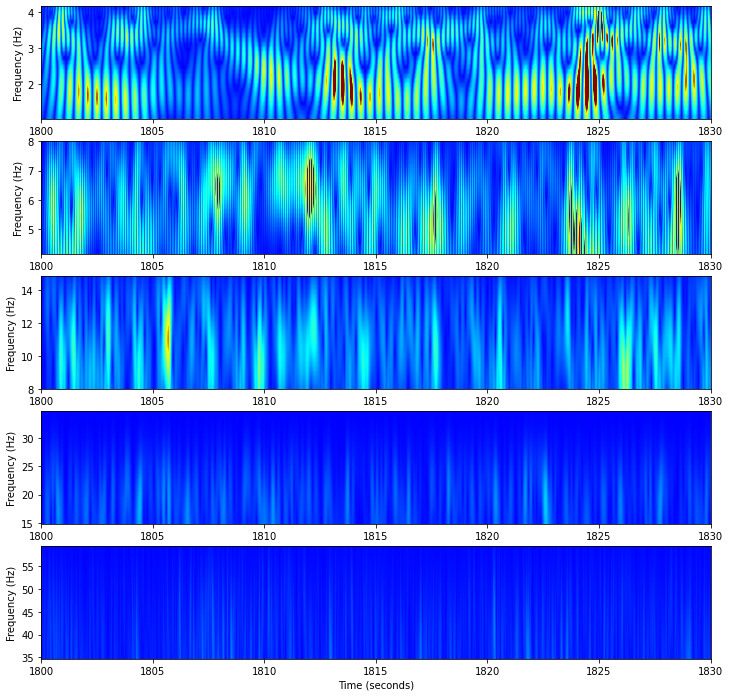

<Figure size 1080x504 with 0 Axes>

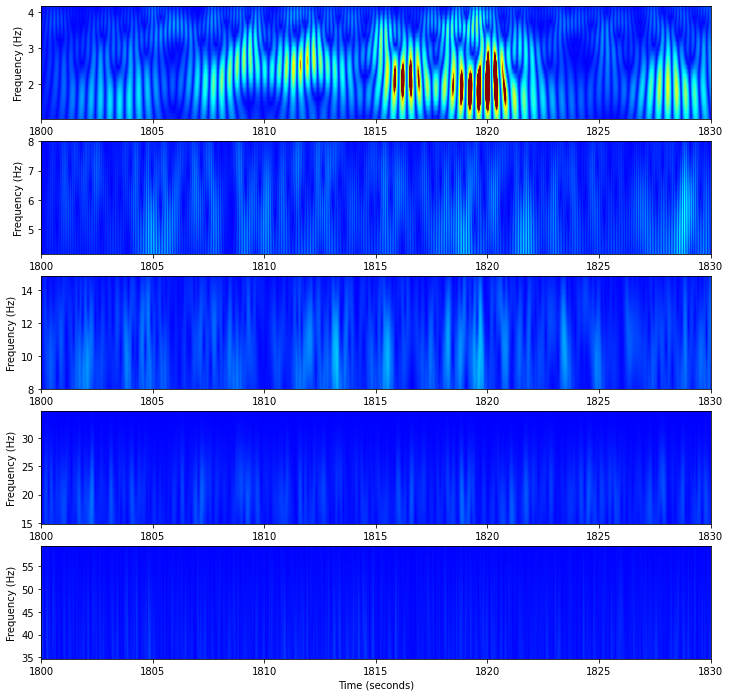

<Figure size 1080x504 with 0 Axes>

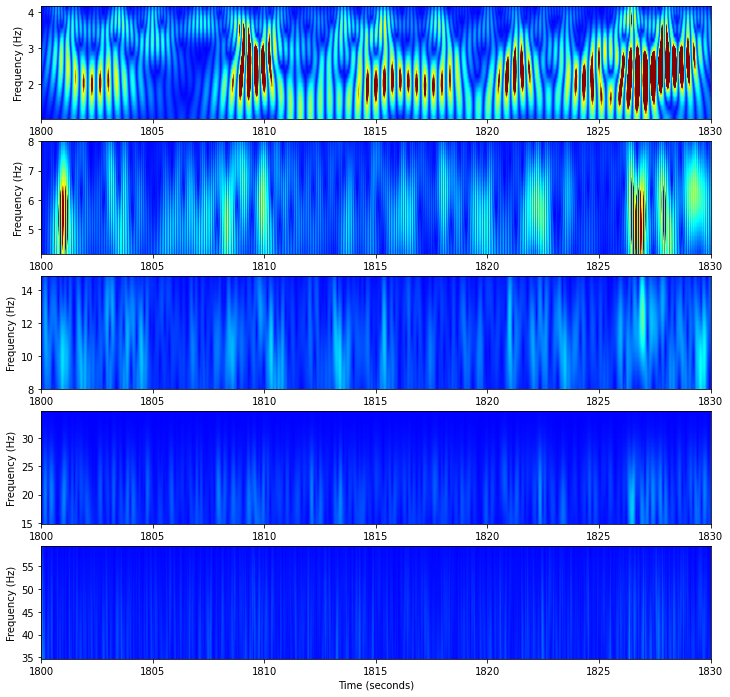

<Figure size 1080x504 with 0 Axes>

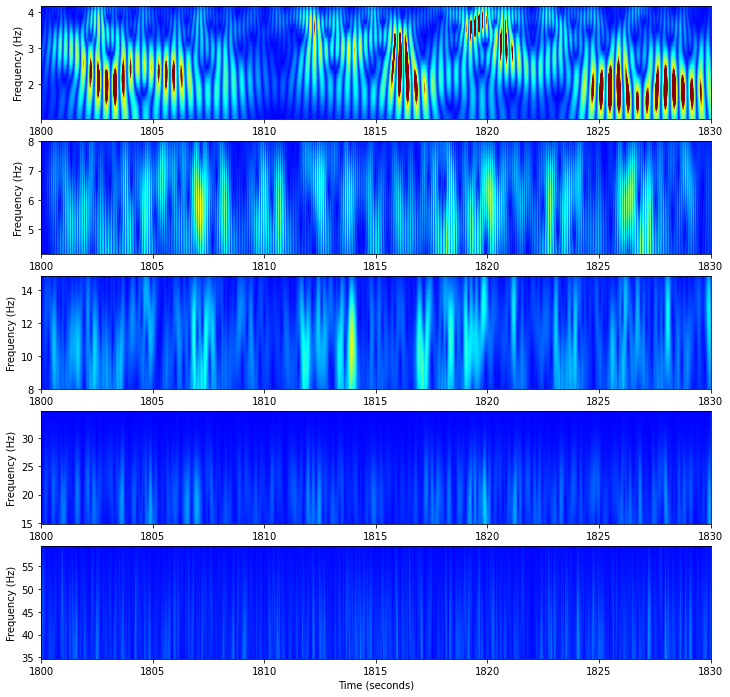

<Figure size 1080x504 with 0 Axes>

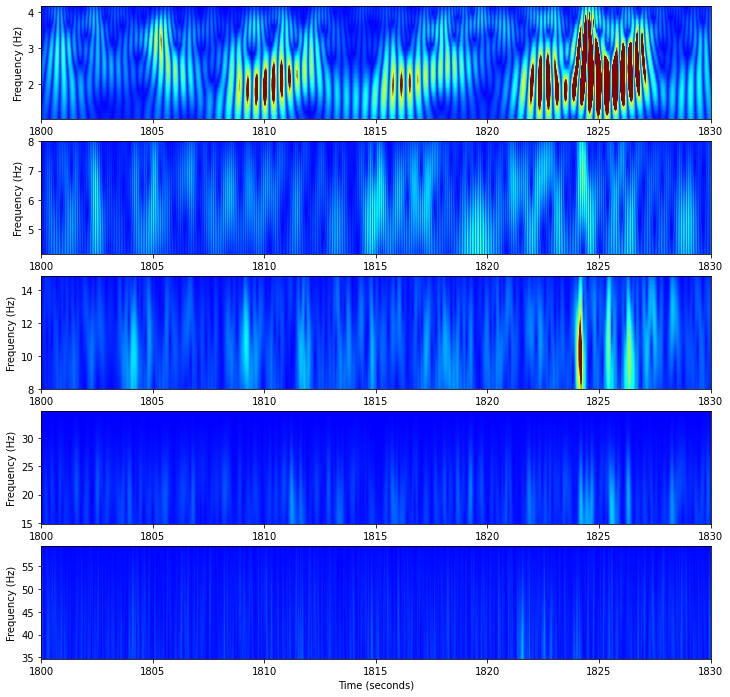

<Figure size 1080x504 with 0 Axes>

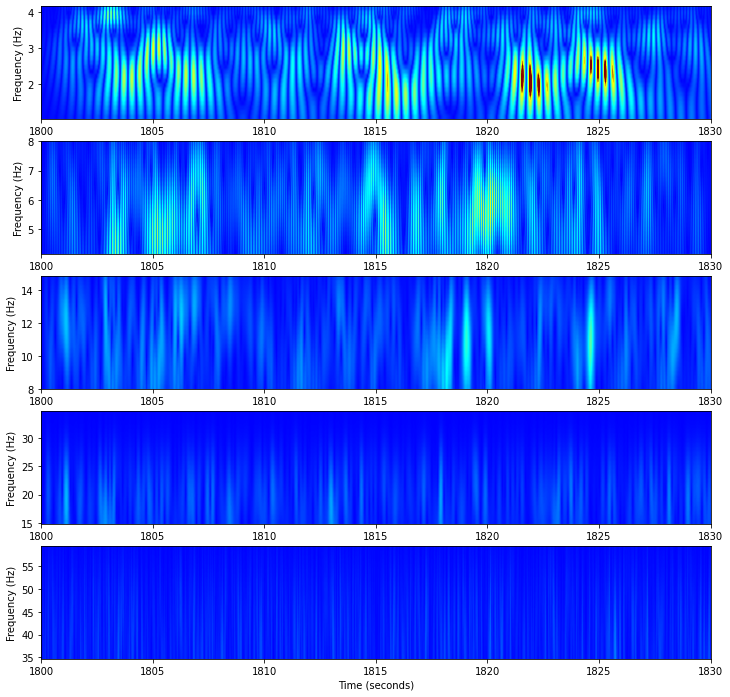

<Figure size 1080x504 with 0 Axes>

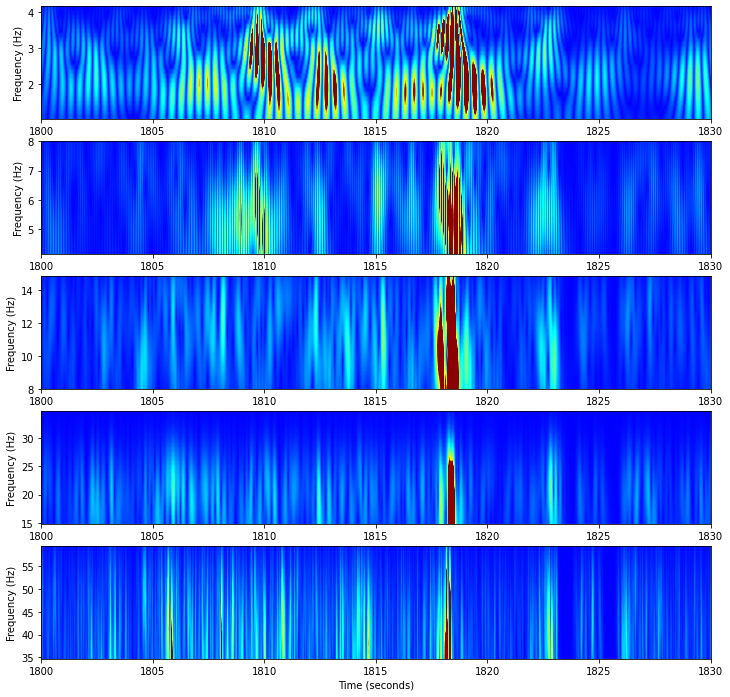

<Figure size 1080x504 with 0 Axes>

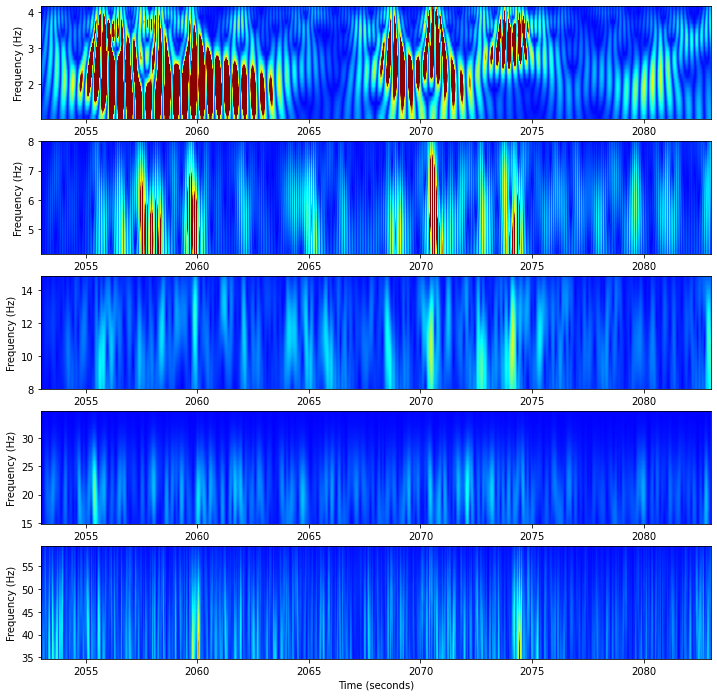

<Figure size 1080x504 with 0 Axes>

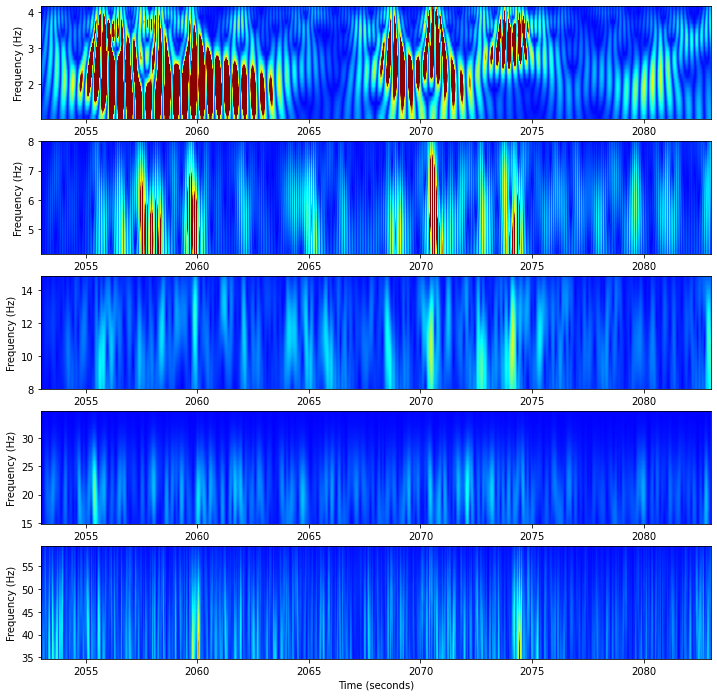

<Figure size 1080x504 with 0 Axes>

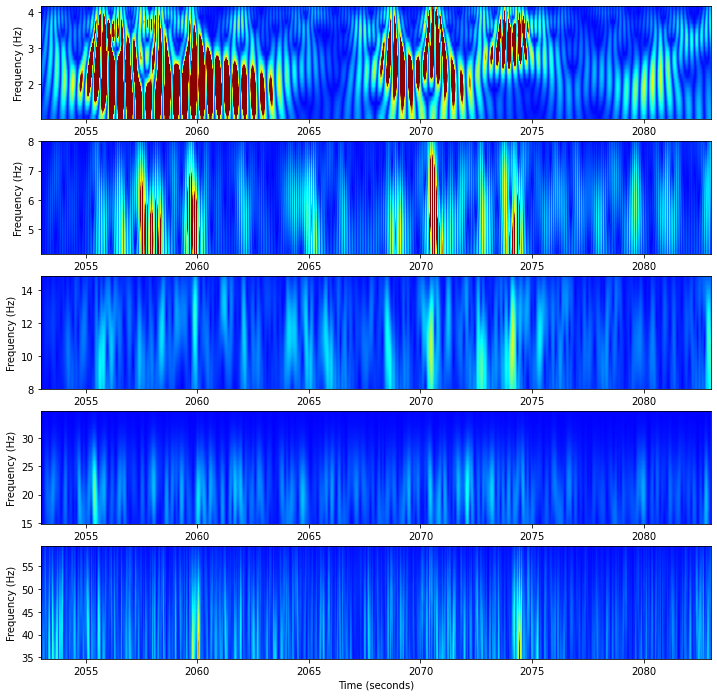

<Figure size 1080x504 with 0 Axes>

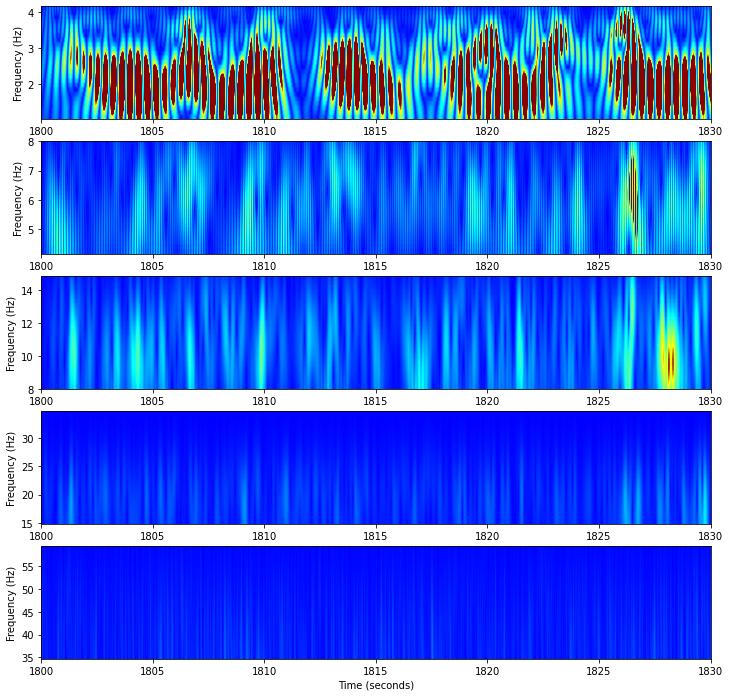

<Figure size 1080x504 with 0 Axes>

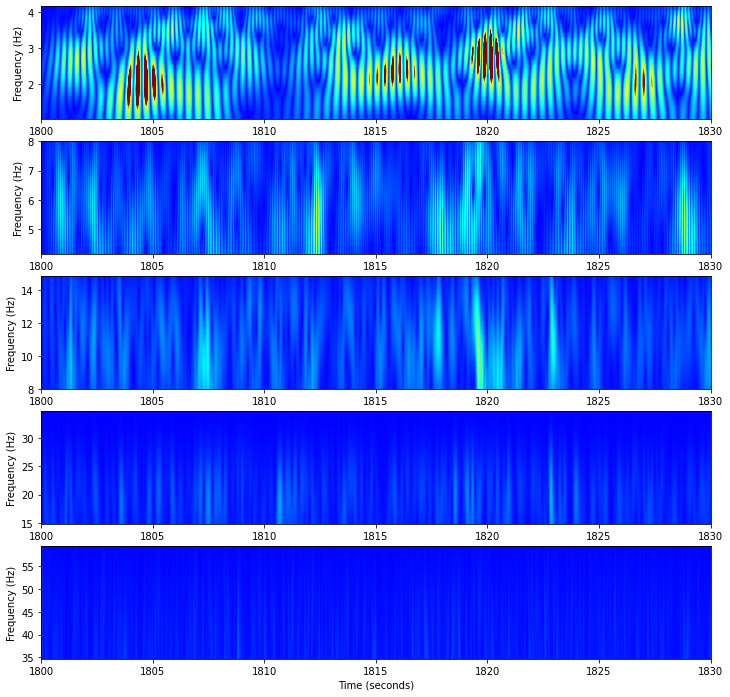

<Figure size 1080x504 with 0 Axes>

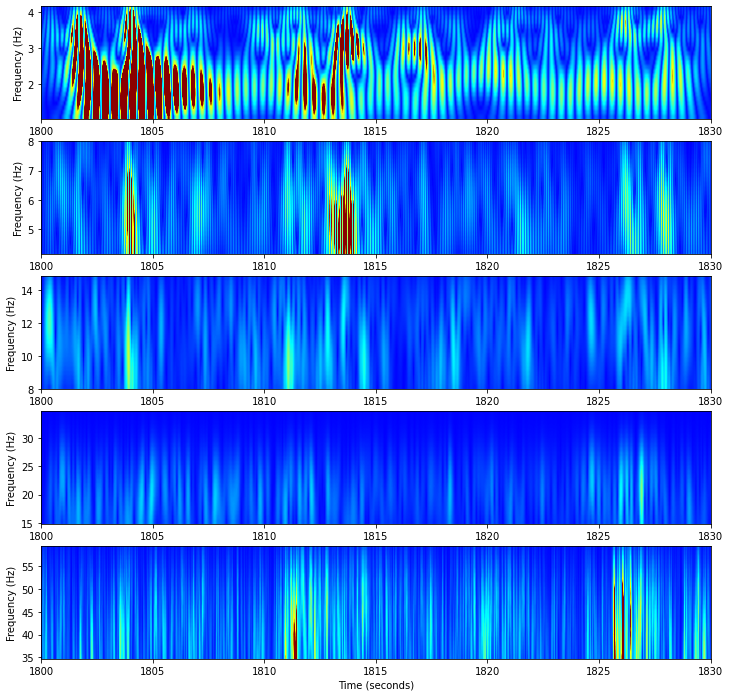

<Figure size 1080x504 with 0 Axes>

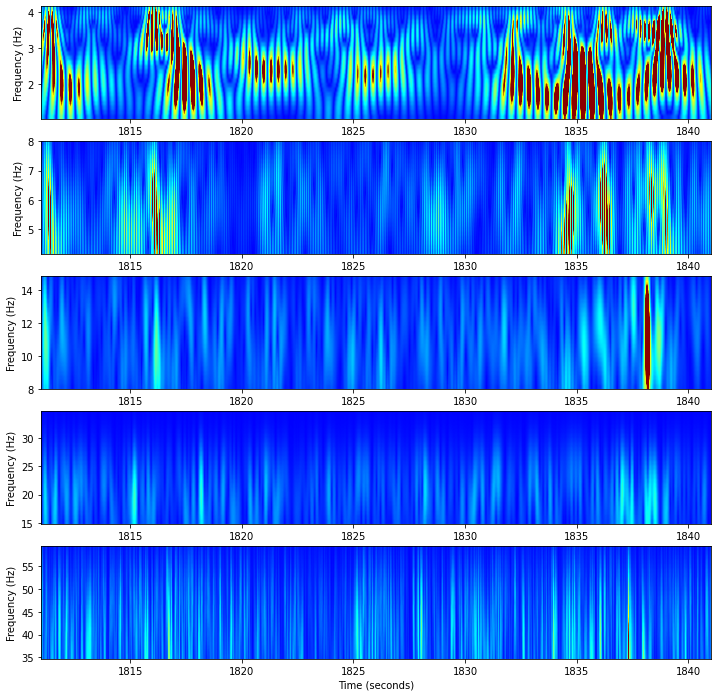

Обработка завершена!


In [42]:
import os
import numpy as np
import shutil

# Параметры обработки
sampling_rate = 256  # Частота дискретизации (Гц)
window_count = 10    # Количество окон для усреднения
output_dir = "processed_data"  # Папка для сохранения результатов


# Основной цикл обработки
for patient_num in range(8, 9):  # Только для patient_num = 8 (chb08)
    patient_id = f"chb0{patient_num}"
    base_path = os.path.expanduser(f"~/Рабочий стол/analytics/physionet.org/files/chbmit/1.0.0/{patient_id}")
    summary_file_path = os.path.join(base_path, f"{patient_id}-summary.txt")
    
    # Парсинг файла описания
    edf_files_list = parse_summary_file(summary_file_path)

    # Обработка каждого EDF-файла
    for edf_file in edf_files_list:
        edf_file_path = os.path.join(base_path, edf_file["file_name"])
        
        # Проверка существования файла
        if not os.path.exists(edf_file_path):
            print(f"Файл не найден: {edf_file_path}")
            continue
            
        # Чтение данных ЭЭГ
        signals, labels = read_edf(edf_file_path)

        # Обработка приступов
        if edf_file['seizure_start']:
            # Генерация изображений для периодов перед приступом
            seizure_times = [(30, '30_sec_before'), 
                            (30, '60_sec_before'), 
                            (30, '90_sec_before')]
            
            for seiz_idx, (seiz_st, seiz_en) in enumerate(zip(edf_file['seizure_start'], 
                                                             edf_file['seizure_end'])):
                for time_offset, time_label in seizure_times:
                    # Подготовка временного окна
                    time_window_start = seiz_st - time_offset
                    time_window_end = seiz_st
                    time_window_start_samples = int(time_window_start * sampling_rate)
                    time_window_end_samples = int(time_window_end * sampling_rate)
                    
                    # Обработка сигналов
                    signal_s = np.delete(signals, [len(signals)-1], axis=0)
                    time = np.arange(time_window_start, time_window_end, 1/sampling_rate)
                    
                    # Усреднение и фильтрация
                    avg_signal = np.mean(signal_s[:, time_window_start_samples:time_window_end_samples], axis=0)
                    filtered_data = butter_bandpass_filter(avg_signal, sampling_rate, plot_signal=False)
                    filtered_mean = mean_delete(filtered_data, window_count, sampling_rate, time, plot_signal=False)
                    
                    # Сохранение изображения
                    save_dir = os.path.join(output_dir, 'Seizure')
                    os.makedirs(save_dir, exist_ok=True)
                    image_name = f"{edf_file['file_name'].replace('.edf', '')}_{time_label}_{seiz_idx+1}_wavelet.png"
                    save_wavelet_transform(filtered_mean, image_name, save_dir,
                                         time_window_start, time_window_end, 
                                         sampling_rate, time_label)
        else:
            # Обработка здоровых записей
            time_window_start = int(signals.shape[1]/sampling_rate/2)
            time_label = 30
            time_window_end = time_window_start + time_label
            
            # Обработка сигналов
            time_window_start_samples = time_window_start * sampling_rate
            time_window_end_samples = time_window_end * sampling_rate
            signals = np.delete(signals, [len(signals)-1], axis=0)
            time = np.arange(time_window_start, time_window_end, 1/sampling_rate)
            
            # Усреднение и фильтрация
            avg_signal = np.mean(signals[:, time_window_start_samples:time_window_end_samples], axis=0)
            filtered_data = butter_bandpass_filter(avg_signal, sampling_rate, plot_signal=False)
            filtered_mean = mean_delete(filtered_data, window_count, sampling_rate, time, plot_signal=False)
            
            # Сохранение изображения
            save_dir = os.path.join(output_dir, 'Healthy')
            os.makedirs(save_dir, exist_ok=True)
            image_name = f"{edf_file['file_name'].replace('.edf', '')}_{time_label}_wavelet.png"
            save_wavelet_transform(filtered_mean, image_name, save_dir,
                                 time_window_start, time_window_end, 
                                 sampling_rate, time_label)

print("Обработка завершена!")

In [48]:

import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight, shuffle
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
     

In [43]:
# Функция для загрузки изображений
def load_images(image_dir, target_size):
    images = []
    labels = []
    for class_dir in ['Healthy', 'Seizure']:  # Подкаталоги классов
        class_path = os.path.join(image_dir, class_dir)
        label = 0 if class_dir == 'Healthy' else 1  # Классы кодируются как 0 или 1
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            # plt.figure()
            # plt.imshow(img)
            img = tf.image.resize(img, target_size)  # Изменение размеров изображения
            images.append(img)
            labels.append(label)
    plt.show()
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [44]:

# Функция для вывода изображений с метками
def display_samples(X, y, num_samples, dataset_name="Dataset"):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        # plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i,:,:,:])
        plt.title(f"Label: {np.argmax(y[i])}")
        plt.axis('off')
    plt.suptitle(f"Sample images from {dataset_name}")
    plt.show()

In [49]:

# Путь к директории с изображениями
image_dir = '/home/omar/Рабочий стол/analytics/content/processed_data'
os.chdir(image_dir)


# Загрузка данных
#X, y = load_images(image_dir, (700,700))
X, y = load_images(image_dir, (512,512))
# print(X[1,32,32,:])
# Масштабирование изображений (нормализация)
# X = X / 255.0
X, y = shuffle(X, y, random_state=24)
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2025-05-26 01:20:08.445320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: omar-desktop
2025-05-26 01:20:08.445336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: omar-desktop
2025-05-26 01:20:08.445392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2025-05-26 01:20:08.445415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.256.2


In [51]:

# Преобразование меток в категориальный формат (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

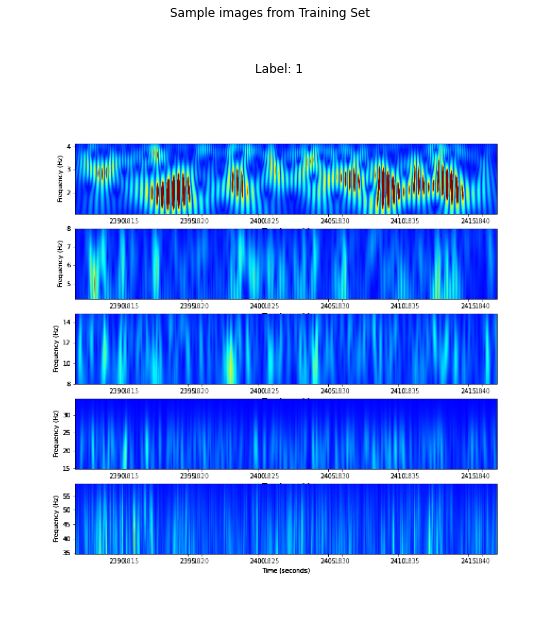

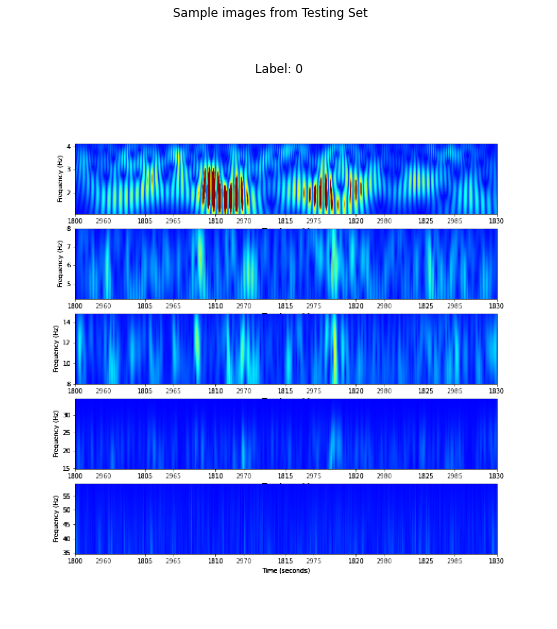

In [52]:


# Вывод примеров из тестовой выборки
# Вывод примеров из обучающей выборки
display_samples(X_train, y_train, num_samples=3, dataset_name="Training Set")
display_samples(X_test, y_test, num_samples=3, dataset_name="Testing Set")


In [53]:
# Создание модели CNN-LSTM
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    # Cверточные слои
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))


    # Преобразование для LSTM
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)))  # Регуляризация L2
    # model.add(Dropout(0.5))
    model.add(Reshape((1, -1)))  # Преобразуем в последовательность длины 1 для LSTM
    model.add(LSTM(64, return_sequences=False))  # Первый LSTM слой
    # model.add(Dropout(0.3))

    # Полносвязный слой
    model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)))
    # model.add(Dropout(0.5))

    # Выходной слой для двух классов
    model.add(Dense(2, activation='sigmoid'))  # Для классификации на 2 класса

    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Инициализация модели
input_shape = (512, 512, 4)  # Изображения 64x64 с 3 каналами (RGB)
model = create_cnn_lstm_model(input_shape)
model.summary()

2025-05-26 01:21:18.257401: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-05-26 01:21:18.279082: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-05-26 01:21:18.291111: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      1184      
                                                                 
 batch_normalization (Batch  (None, 512, 512, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 64)      0

In [55]:


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)
# Преобразование меток обратно из one-hot encoding в одномерный массив меток

y_train_classes = np.argmax(y_train, axis=1)

# Вычисление весов классов
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Преобразование class_weights в словарь, так как model.fit ожидает словарь
class_weights_dict = dict(enumerate(class_weights))
checkpoint = ModelCheckpoint(
    "best_weights.keras",  # Имя файла для сохранения весов
    monitor="val_accuracy",  # Метрика для отслеживания
    save_best_only=True,     # Сохранять только если улучшилась метрика
    mode="max",              # "max" для максимизации метрики
    verbose=1
)
# Обучение модели с указанием весов классов
history = model.fit(X_train, y_train, epochs=40, batch_size=8, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping] )
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Печать результатов оценки
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))
print("Accuracy:", accuracy_score(y_true, y_pred_classes))

     

Epoch 1/40


2025-05-26 01:21:43.377360: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-05-26 01:21:43.385352: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


3/3 [==============================] - 6s 1s/step - loss: 9.3499 - accuracy: 0.5263 - val_loss: 10.5050 - val_accuracy: 0.6000
Epoch 2/40
3/3 [==============================] - 3s 1s/step - loss: 11.2398 - accuracy: 0.5263 - val_loss: 12.5969 - val_accuracy: 0.6000
Epoch 3/40
3/3 [==============================] - 3s 1s/step - loss: 12.7758 - accuracy: 0.5263 - val_loss: 12.7472 - val_accuracy: 0.6000
Epoch 4/40
3/3 [==============================] - 4s 1s/step - loss: 12.6077 - accuracy: 0.5263 - val_loss: 11.8650 - val_accuracy: 0.6000
Epoch 5/40
3/3 [==============================] - 4s 1s/step - loss: 11.5713 - accuracy: 0.5263 - val_loss: 10.4918 - val_accuracy: 0.6000
Epoch 6/40
3/3 [==============================] - 3s 1s/step - loss: 10.1681 - accuracy: 0.5263 - val_loss: 8.9830 - val_accuracy: 0.6000
Epoch 7/40
3/3 [==============================] - 4s 1s/step - loss: 8.6431 - accuracy: 0.5263 - val_loss: 7.6014 - val_accuracy: 0.6000
Epoch 8/40
3/3 [==========================

/home/omar/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


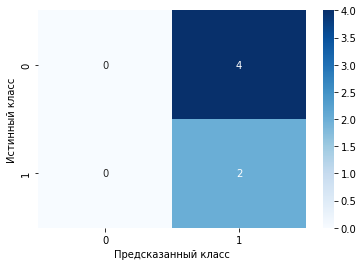

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [56]:

# Построение матрицы ошибок
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
class_names = ['Содержащий приступ', 'Не содержащий приступ']
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()

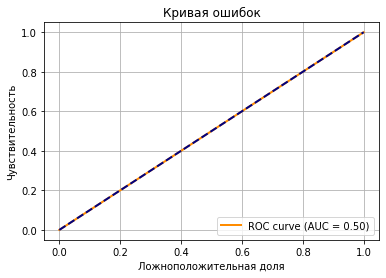

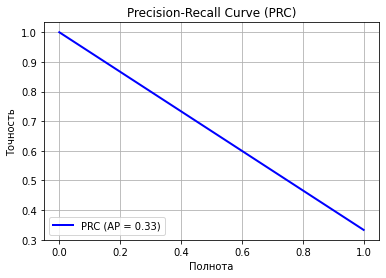

In [57]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_true, y_pred_classes)  # Используем вероятности для классов

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Диагональная линия
plt.xlabel('Ложноположительная доля')
plt.ylabel('Чувствительность')
plt.title('Кривая ошибок')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Построение Precision-Recall кривой
precision, recall, _ = precision_recall_curve(y_true, y_pred_classes)
average_precision = average_precision_score(y_true, y_pred_classes)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PRC (AP = {average_precision:.2f})')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('Precision-Recall Curve (PRC)')
plt.legend(loc='lower left')
plt.grid()
plt.show()
     


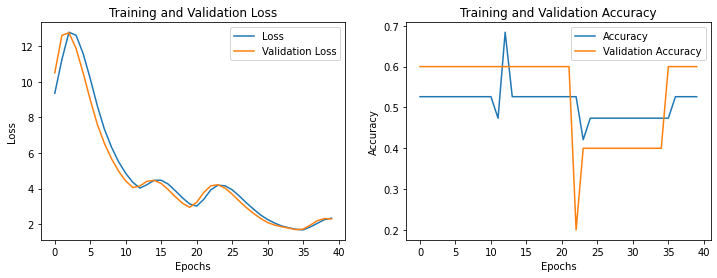

In [58]:
# Визуализация обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.close()  # Закрыть график, чтобы избежать наложения